generating 3d point cloud...
Points_Cloud.ply saved


True

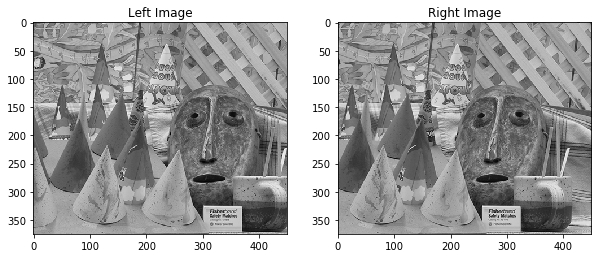

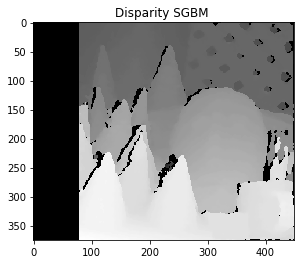

In [24]:
#Disparity StereoSGBM
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
#%matplotlib widget

imgL= 'im2.png'
imgR= 'im6.png'

img1_undistorted = cv.imread(imgL, 0)
img2_undistorted = cv.imread(imgR, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax1.imshow(img1_undistorted, cmap='gray')
ax1.set_title('Left Image')
im2 = ax2.imshow(img2_undistorted, cmap='gray')
ax2.set_title('Right Image')

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')


#https://docs.opencv.org/4.5.2/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 5
min_disp = 0
max_disp = 16*5
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 50
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 1
disp12MaxDiff = 1#the maximum allowed difference between the disparities calculated from left to right and those calculated from right to left

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size)

#Disparity map is divided by 16.0 as it is a scaling factor used by StereoSGBM, which must be accounted for
disp = stereo.compute(img1_undistorted, img2_undistorted)
disp = disp.astype(np.float32) / 16.0

print('generating 3d point cloud...',)
h, w = img1_undistorted.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis, 
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(disp, Q)
#points = points[np.sum(np.isinf(points) + np.isnan(points), axis=1) == 0]
colors = cv.cvtColor(cv.imread(imgL), cv.COLOR_BGR2RGB)
mask = disp > disp.min()
out_point = points[mask]
out_color = colors[mask]
out_points = out_point[np.sum(np.isinf(out_point) + np.isnan(out_point), axis=1) == 0,:]
out_colors = out_color[np.sum(np.isinf(out_point) + np.isnan(out_point), axis=1) == 0,:]
out_fn = 'Points_Cloud.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disp, disp, alpha=255,beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

plt.figure()
plt.imshow(disparity_SGBM, cmap ='gray'), plt.title('Disparity SGBM ')
cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

True

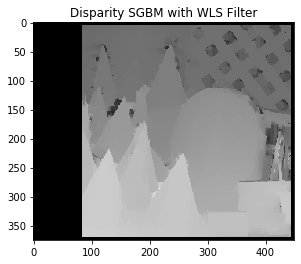

In [14]:
#Disparity StereoSGBM_WLSFilter
import cv2
import matplotlib.pyplot as plt

imgL= 'im2.png'
imgR= 'im6.png'

left_image = cv2.imread(imgL, 0)
right_image = cv2.imread(imgR, 0)

wsize=11
max_disp = 80
sigma = 1.5
lmbda = 8000.0

left_matcher = cv2.StereoBM_create(max_disp, wsize)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
left_disp = left_matcher.compute(left_image, right_image)
right_disp = right_matcher.compute(right_image,left_image)
#Normalize
left_disp = left_disp.astype(np.float32) / 16.0
right_disp = right_disp.astype(np.float32) / 16.0

# Now create DisparityWLSFilter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(left_matcher);
wls_filter.setLambda(lmbda);
wls_filter.setSigmaColor(sigma);
filtered_disp = wls_filter.filter(left_disp, left_image, disparity_map_right=right_disp);

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(filtered_disp, filtered_disp, alpha=255,beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

plt.figure()
plt.imshow(disparity_SGBM, cmap ='gray'), plt.title('Disparity SGBM with WLS Filter')
cv.imwrite("disparity_SGBM_filtered.png", disparity_SGBM)

In [11]:
#SAD (Sum of Absolute Differences) block matching variant
import cv2 as cv
from os.path import splitext
import matplotlib.pyplot as plt
import time as t

from depthy.stereo import sad_block_matching, sad_block_match_vector
from depthy.misc.io_functions import load_img_file
from depthy.stereo.helper_funs import auto_disp_limits
from depthy.misc import Normalizer

imgL= 'im2.png'
imgR= 'im6.png'

img_l = load_img_file(imgL)
img_r = load_img_file(imgR)

disp_lim = auto_disp_limits(img_l, img_r)
print('\nDetected disparity range [min, max] amounts to %s.' % disp_lim)

dawn = t.time()

disp_map_l, _ = sad_block_match_vector(img_l, img_r, disp_max=disp_lim[1], disp_min=disp_lim[0], ws=25, prec=1)
disp_map_r, _ = sad_block_matching(img_r, img_l, disp_max=disp_lim[1], disp_min=disp_lim[0] - 1, ws=25, prec=10)

dusk = t.time()
print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))

# save images
output_name = 'Cones-disp_sad.png'
plt.imsave(fname=splitext(output_name)[0]+'_l.png', arr=Normalizer(disp_map_l).uint8_norm(), cmap='gray')
plt.imsave(fname=splitext(output_name)[0]+'_l.png', arr=Normalizer(disp_map_r).uint8_norm(), cmap='gray')


Detected disparity range [min, max] amounts to [0, 60].

Compute block matching cost...
100 %

Finished

Total execution time = 677.91s


In [15]:
#Semi-global matching variant covering feature extraction, dissimilarity measure and cost aggregation
import cv2
from os.path import splitext
import matplotlib.pyplot as plt
import time as t

from depthy.stereo import semi_global_matching
from depthy.misc.io_functions import load_img_file
from depthy.misc import Normalizer

imgL= 'im2.png'
imgR= 'im6.png'
print('\nLoad images...')
img_l = load_img_file(imgL)
img_r = load_img_file(imgR)

dawn = t.time()

l_disparity_map, r_disparity_map = semi_global_matching(img_l, img_r, feat_method='census', dsim_method='xor')

dusk = t.time()
print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))

# save images
output_name = 'Cones-disp_sgm.png'
plt.imsave(fname=splitext(output_name)[0]+'_l.png', arr=Normalizer(l_disparity_map).uint8_norm(), cmap='gray')
plt.imsave(fname=splitext(output_name)[0]+'_r.png', arr=Normalizer(r_disparity_map).uint8_norm(), cmap='gray')


Load images...

Feature computation...
	Left and right census...	(done in 20.88s)

Cost computation...
	Similarity from xor method...	(done in 115.17s)

Left aggregation computation...
	Process paths vertical...	(done in 49.23s)
	Process paths horizontal...	(done in 44.95s)
	Process paths ascending...	(done in 45.81s)
	Process paths descending...	(done in 45.69s)

Right aggregation computation...
	Process paths vertical...	(done in 49.92s)
	Process paths horizontal...	(done in 48.61s)
	Process paths ascending...	(done in 55.09s)
	Process paths descending...	(done in 54.18s)

Finished

Total execution time = 536.59s


In [ ]:
#http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html
import open3d

pcd = open3d.io.read_point_cloud('Points_Cloud.ply')
open3d.visualization.draw_geometries([pcd])